# Data Camp 2024 -  Pokémon Classification Challenge

**Welcome to our Pokémon Data Challenge! Our team has concocted this thrilling endeavor immersed in the Pokémon universe.**

- <u>***Goal:***</u>
The aim is to forecast a Pokémon's type based on its name across various languages: French, English, German, and Japanese. Additionally, you have the liberty to incorporate Pokémon images to enrich your analysis.

- *Data source :* All the data stems from the website called [Pokepedia](https://www.pokepedia.fr/Liste_des_Pok%C3%A9mon_dans_l%27ordre_du_Pok%C3%A9dex_National), where a plethora of Pokémon names and details were discovered.

- *Delving into methodology (optional) :* Should you harbor curiosity about the methodology behind our data acquisition, delve into our "scrapping_pokemon.ipyn" notebook. It shows all the steps we took to collect the names and pictures from the website.

Here is a starting kit to start your predictions.

**Let the challenge begin!**

In [1]:
%matplotlib ipympl

In [2]:
# Check if the code is running on Google Colab
try:
    from google.colab import drive
    IN_COLAB = True
except ImportError:
    IN_COLAB = False

## Importing librairies

In [3]:
import numpy as np
import pandas as pd
from PIL import Image, ImageOps
import os
import matplotlib.pyplot as plt
import umap
from wordcloud import WordCloud
import re
import cv2


from scipy.special import softmax

from sklearn.base import BaseEstimator
from sklearn.compose import ColumnTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.multioutput import MultiOutputClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.pipeline import make_pipeline
from sklearn.utils.validation import check_is_fitted
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, Dataset

## Loading the textual data

In [4]:
conversion_table_path = "data/Table/Pokemon_name_and_type.parquet"

In [5]:
df=pd.read_parquet(conversion_table_path)

## Loading Images

In [6]:
def padding(img, expected_size):
    desired_size = expected_size
    delta_width = desired_size[0] - img.size[0]
    delta_height = desired_size[1] - img.size[1]
    pad_width = delta_width // 2
    pad_height = delta_height // 2
    padding = (pad_width, pad_height, delta_width - pad_width, delta_height - pad_height)
    return ImageOps.expand(img, padding)

In [7]:
image_folder_path = "data/Images"

In [8]:
image_list = os.listdir(image_folder_path)
dic = {}
dic_resize = {}
expected_size = (128,128)
for image_name in image_list:
    index=image_name.split("_")[0]
    img = Image.open(os.path.join(image_folder_path, image_name))
    dic[index]=np.array(img)
    img.thumbnail(expected_size, Image.Resampling.LANCZOS)
    img = padding(img, expected_size)
    numpy_array = np.array(img)
    dic_resize[index]=numpy_array
df["image_resized"]=df.index.map(dic_resize)
df["Image"]=df.index.map(dic)

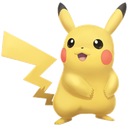

In [9]:
Image.fromarray(df.loc["0025","image_resized"])

In [10]:
colors = {
    'Plant': np.array([34, 139, 34]),       # Green
    'Fire': np.array([255, 69, 0]),           # Red-Orange
    'Water': np.array([30, 144, 255]),         # Blue
    'Bug': np.array([128, 128, 0]),      # Olive
    'Normal': np.array([169, 169, 169]),     # Dark Gray
    'Poison': np.array([128, 0, 128]),       # Purple
    'Electric': np.array([255, 215, 0]),     # Gold
    'Ground': np.array([210, 105, 30]),         # Chocolate
    'Fairy': np.array([255, 192, 203]),        # Pink
    'Fighting': np.array([205, 92, 92]),       # Indian Red
    'Psychic': np.array([123, 104, 238]),        # Medium Slate Blue
    'Rock': np.array([139, 69, 19]),        # Saddle Brown
    'Ghost': np.array([138, 43, 226]),     # Blue Violet
    'Ice': np.array([135, 206, 235]),      # Sky Blue
    'Dragon': np.array([106, 90, 205]),      # Slate Blue
    'Dark': np.array([47, 79, 79]),      # Dark Slate Gray
    'Steel': np.array([192, 192, 192]),      # Silver
    'Flying': np.array([70, 130, 180])          # Steel Blue
}

# Data exploration 

## Image data exploration

### UMAP - Uniform Manifold Approximation and Projection

Let's create a scatter plot illustrating a UMAP (Uniform Manifold Approximation and Projection) embedding of our Pokémon dataset. UMAP is a robust dimensionality reduction technique commonly employed for visualizing high-dimensional data. In this plot, each point represents a Pokémon, and the colors indicate their respective types. The position of each point is determined by the UMAP algorithm, which assesses the similarity of the images' pixel data

In [11]:
df["vector"] = df["image_resized"].apply(lambda x:x[:,:,:3].flatten())

In [12]:
reducer = umap.UMAP()
types = ["Fire", "Electric", "Water"]
%time 
u_ = reducer.fit_transform(np.stack(df.loc[df["Type 1"].isin(types), "vector"], axis=0))

CPU times: total: 0 ns
Wall time: 0 ns


In [13]:
df["color"]=df["Type 1"].map(colors)

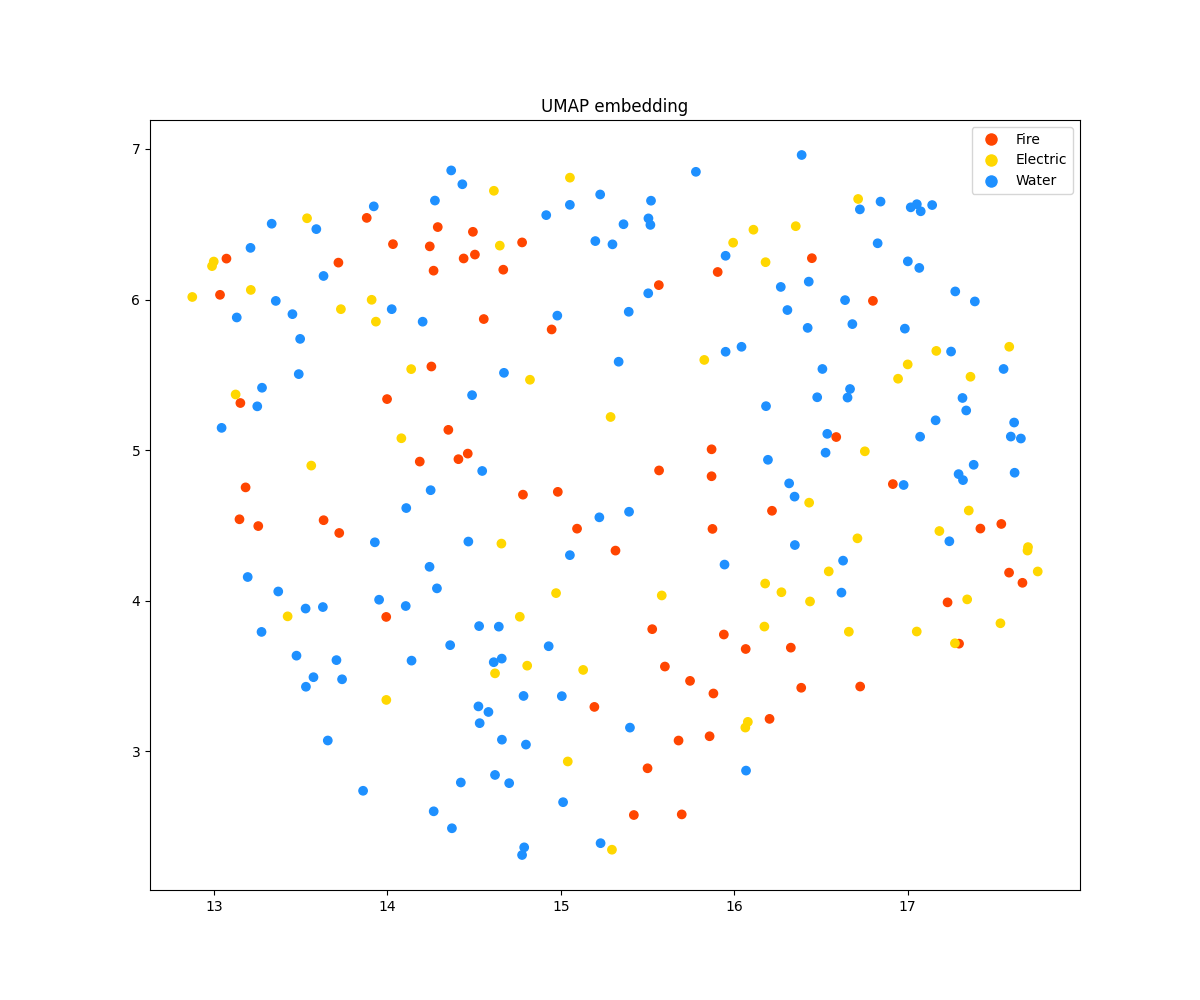

In [14]:
plt.figure(figsize=(12, 10))  # Adjust the width and height as needed
plt.scatter(u_[:,0], u_[:,1], c=df.loc[df["Type 1"].isin(types), "color"]/255)
# Add legend with types and colors
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=label,
                              markersize=10, markerfacecolor=colors[label]/255) for label in types]
plt.legend(handles=legend_handles, labels=types)

plt.title('UMAP embedding')
plt.show()

### Mean color

Now we display a 3D scatter plot representing the average colour values extracted from images of Pokémon of three different types: Fire, Electric, and Water. Using the RGB colour space, the position of each point is determined by the average red (R), green (G), and blue (B) pixel values for each image.

In [15]:
img_array = df.loc["0001", "image_resized"]
img = Image.fromarray(img_array)

In [16]:
def nan_mean_dataframe(rgb, alpha):
    image_temp = rgb.copy().astype(np.float32)
    image_temp[alpha == 0] = np.nan
    return np.nanmean(image_temp.reshape(-1,3), axis=0)

df["rgb_values"] = df["image_resized"].apply(lambda x:x[:,:,:3])
df["alpha_channel"] = df["image_resized"].apply(lambda x:x[:,:,3])
df["mean_color_value"] = df[["rgb_values", "alpha_channel"]].apply(lambda x:nan_mean_dataframe(x[0], x[1]), axis=1)

C:\Users\wande\AppData\Local\Temp\ipykernel_18808\574065246.py:8: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  df["mean_color_value"] = df[["rgb_values", "alpha_channel"]].apply(lambda x:nan_mean_dataframe(x[0], x[1]), axis=1)


In [17]:
df[["Type 1","mean_color_value"]]

,Type 1,mean_color_value
Number,,
0001,Plant,"[109.89778, 156.39117, 134.19037]"
0002,Plant,"[101.859924, 139.78908, 140.74796]"
0003,Plant,"[104.78638, 119.612144, 116.31939]"
0004,Fire,"[186.51294, 146.77669, 119.91799]"
0005,Fire,"[189.45543, 122.29989, 103.43847]"
...,...,...
1021,Electric,"[178.34544, 164.97894, 147.11147]"
1022,Rock,"[167.60175, 151.88596, 131.8171]"
1023,Steel,"[123.41835, 161.08537, 160.64685]"


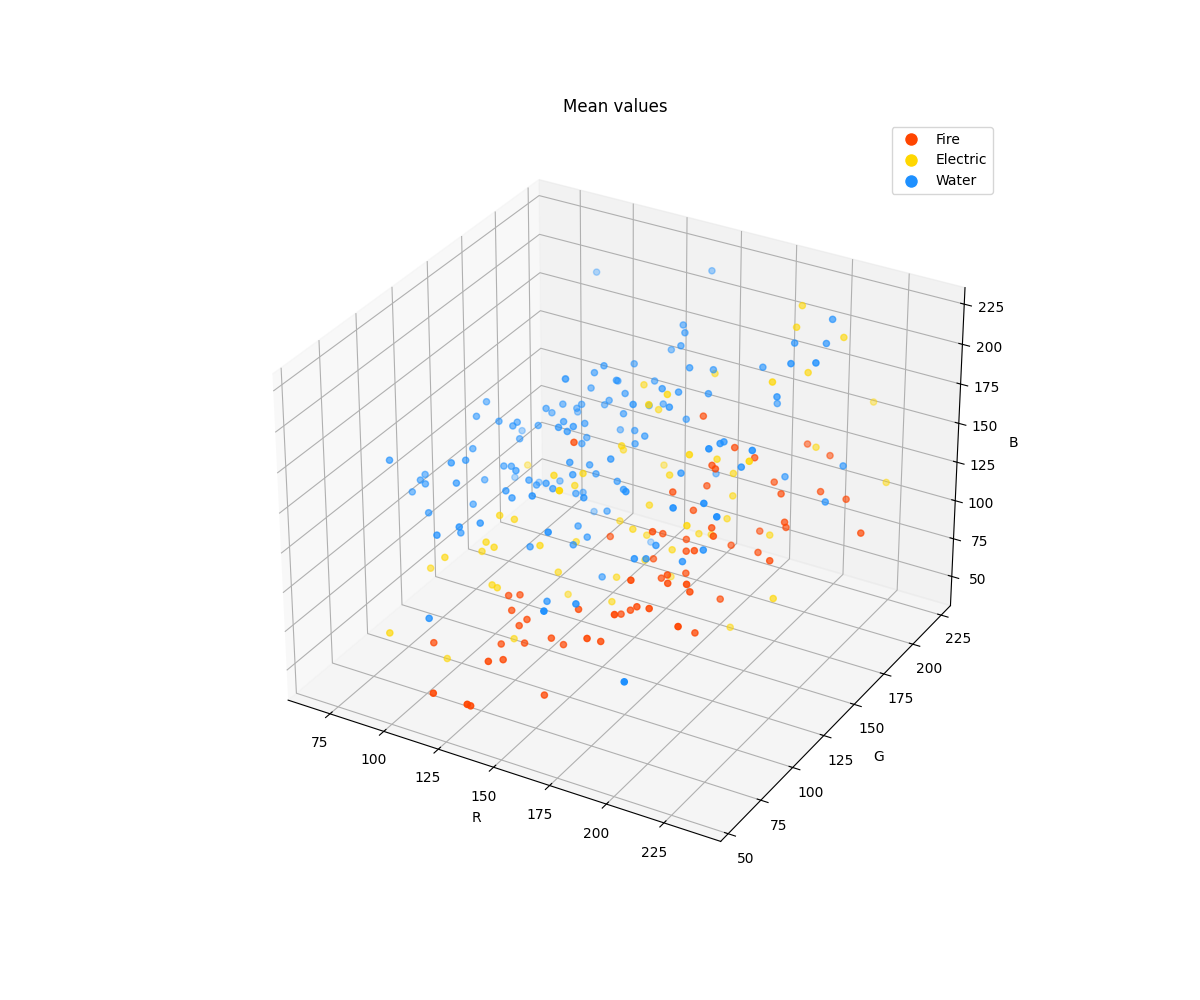

In [18]:
types = ["Fire", "Electric", "Water"]

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot in 3D
u = np.stack(df.loc[df["Type 1"].isin(types), "mean_color_value"], axis=0)
scatter = ax.scatter(u[:, 0], u[:, 1], u[:, 2], c=df.loc[df["Type 1"].isin(types),"color"]/255)

# Add legend with types and colors
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=label,
                             markersize=10, markerfacecolor=colors[label]/255) for label in types]
ax.legend(handles=legend_handles, labels=types)

ax.set_xlabel('R')
ax.set_ylabel('G')
ax.set_zlabel('B')

ax.set_title('Mean values')
plt.show()

Through this approach, discernible clusters start to emerge,even if there are not very well defined. As an exemple, a significant proportion of Fire-type Pokémon predominantly occupy the lower region of the plot.

To be more precise, we will attempt to extract the dominant color instead of the mean color.

In [19]:
def extract_dominant_color(image, k=3):
    pixels = image["rgb_values"][image["alpha_channel"] != 0]
    # Reshape the image to be a list of pixels
    pixels = pixels.reshape((-1, 3))

    # Convert to float
    pixels = np.float32(pixels)

    # Define criteria for k-means
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 100, 0.2)

    # Apply k-means clustering
    compactness, labels, centers = cv2.kmeans(pixels, k, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)

    # Get the counts for each label
    label_counts = np.bincount(labels.flatten())

    # Get the index of the most frequent label (dominant color)
    most_dominant_label = np.argmax(label_counts)

    # Get the most dominant color
    most_dominant_color = centers[most_dominant_label]

    # Convert centers to integer
    most_dominant_color = np.uint8(most_dominant_color)

    # Return the dominant colors
    return most_dominant_color

In [20]:
df["dominant_color"] = df[["rgb_values", "alpha_channel"]].apply(extract_dominant_color, axis=1)

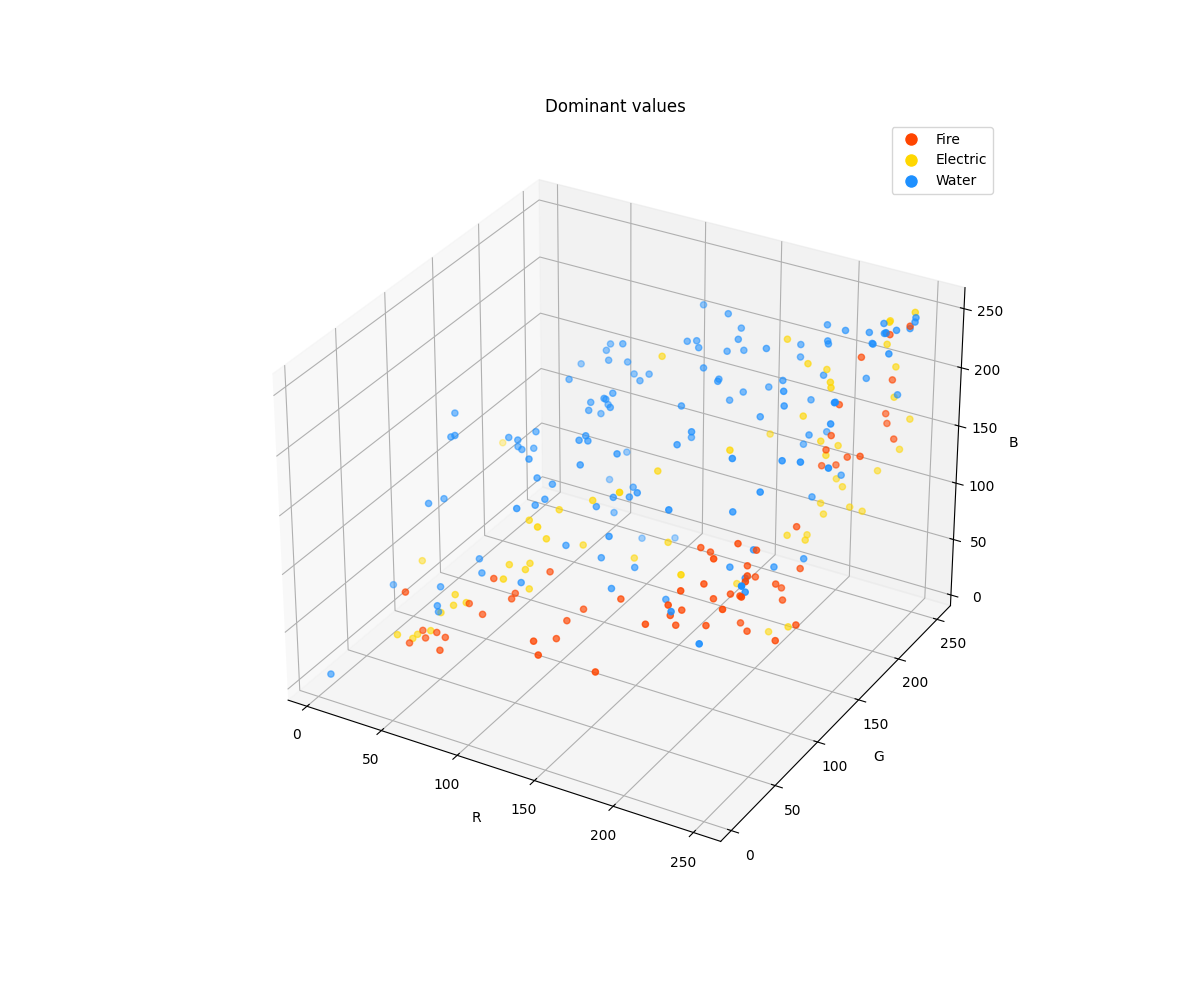

In [21]:
types = ["Fire", "Electric", "Water"]

fig = plt.figure(figsize=(12, 10))
ax = fig.add_subplot(111, projection='3d')

# Scatter plot in 3D
u = np.stack(df.loc[df["Type 1"].isin(types), "dominant_color"], axis=0)
scatter = ax.scatter(u[:, 0], u[:, 1], u[:, 2], c=df.loc[df["Type 1"].isin(types),"color"]/255)

# Add legend with types and colors
legend_handles = [plt.Line2D([0], [0], marker='o', color='w', label=label,
                             markersize=10, markerfacecolor=colors[label]/255) for label in types]
ax.legend(handles=legend_handles, labels=types)

ax.set_xlabel('R')
ax.set_ylabel('G')
ax.set_zlabel('B')

ax.set_title('Dominant values')
plt.show()

 This 3D scatter plot of dominant colors gives a more nuanced view of the color characteristics of Pokémon types than the average color analysis. It can be seen that there's a better distinction between types compared to the plot using mean color values.

## Textual data exploration

In a second step, we propose to use textual data to infer the *type* of a pokemon. Indeed Pokemons names often carry significant meanings.
For example the name *Hitokage* literally translates to "fire lizard," as evidenced by its components 火 (hi) meaning fire and 蜥蜴 (tokage) meaning lizard. Similar linguistic wordplays can be found in english and french; for instance, *Charmander* originates from "Char," signifying "to burn" in english, and "mander" derived from the animal name "Salamander". Salamèche is the contraction of "Sala" from Salamandre in french and "mèche" (a fuse).

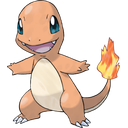

In [22]:
Image.fromarray(df.loc["0004","image_resized"])

In [23]:
df[["French", "English", "German", "Kanas", "Type 1", "Type 2"]].iloc[20:30]

,French,English,German,Kanas,Type 1,Type 2
Number,,,,,,
0021,Piafabec,Spearow,Habitak,オニスズメ,Normal,Flying
0022,Rapasdepic,Fearow,Ibitak,オニドリル,Normal,Flying
0023,Abo,Ekans,Rettan,アーボ,Poison,None
0024,Arbok,Arbok,Arbok,アーボック,Poison,None
0025,Pikachu,Pikachu,Pikachu,ピカチュウ,Electric,None
0026,Raichu,Raichu,Raichu,ライチュウ,Electric,None
0027,Sabelette,Sandshrew,Sandan,サンド,Ground,None
0028,Sablaireau,Sandslash,Sandamer,サンドパン,Ground,None
0029,Nidoran♀,Nidoran♀,Nidoran♀,ニドラン♀,Poison,None


Of course the textual information can be way more complicated to interpret. Take, for example, the renowned Pikachu, which lacks any clear meaning in languages other than Japanese. Even in Japanese, deciphering its meaning isn't straightforward. The name Pikachu is derived from the amalgamation of two onomatopoeias: ピカピカ (pikapika), representing a sparkling sound, and チューチュー (chūchū), mimicking the squeaking sounds of a mouse. As it turns out, Pikachu is indeed an electric mouse!

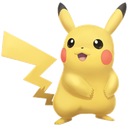

In [24]:
Image.fromarray(df.loc["0025","image_resized"])

We can perform a textual analysis to observe the most common root between the different names. We will perform it on japanese language since this is the original language of the characters name, but the analysis can be done on the other language too.

In [25]:
language = "Kanas"
font_path_Kanas = "fonts/BIZ-UDGOTHICR.TTC" # Specify the path to the font file for this language

def get_substrings(word, n):
    return [word[i:i+n].lower() for i in range(len(word) - n + 1)]

def create_word_cloud(df, language, type, font_path=font_path_Kanas):
    occurences = df.loc[(df["Type 1"] == type) | (df["Type 2"] == type),language+"_substrings"].value_counts()

    dic = occurences[occurences>1].to_dict()    
    wordcloud = WordCloud(width=800, height=400, background_color ='white', font_path=font_path, prefer_horizontal=1).generate_from_frequencies(dic)

    # Display the word cloud using matplotlib
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')  # Remove axis
    plt.show()

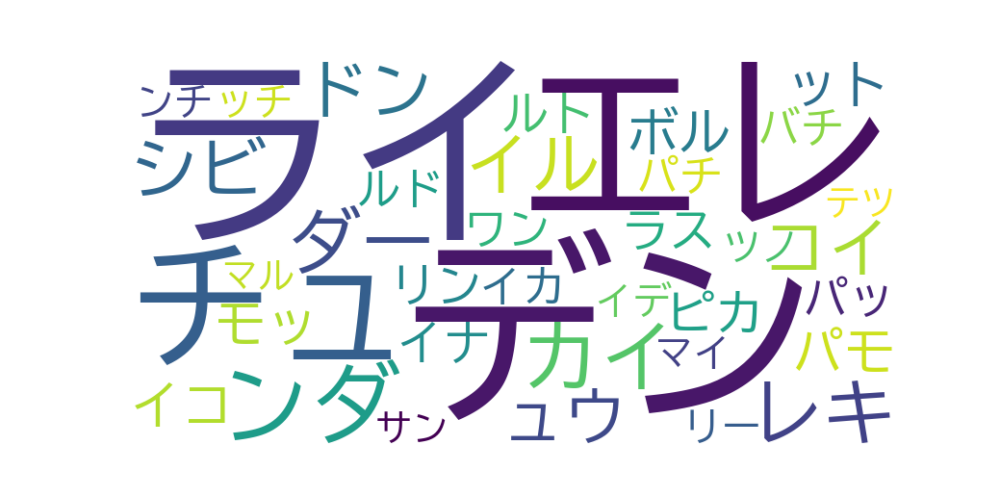

In [26]:
pokemon_type = "Electric"

substring_length = 2
df[language+"_substrings"] = df[language].apply(lambda x: get_substrings(x, substring_length)) # Create a new column in the DataFrame to store substrings extracted from the 'Kanas' column
df_name = df[[language+"_substrings", "Type 1", "Type 2"]].explode(language+"_substrings") # Create a new DataFrame with columns for substrings, 'Type 1', and 'Type 2', with each substring exploded into its own row

# Generate a word cloud using the specified DataFrame, language, Pokémon type, and font path
create_word_cloud(df_name, language, pokemon_type, font_path_Kanas)

One can effectively notice the multiple Pokemons which an electric type share the kanas :
- デン (den) which comes from 電気 (denki - electricity)
- ライ (rai) which comes from 雷 (rai - thunder)
- エレ (ele) which can be found in the japanese pronunciation of electricity (エレキ), electronics (エレクトロニクス)

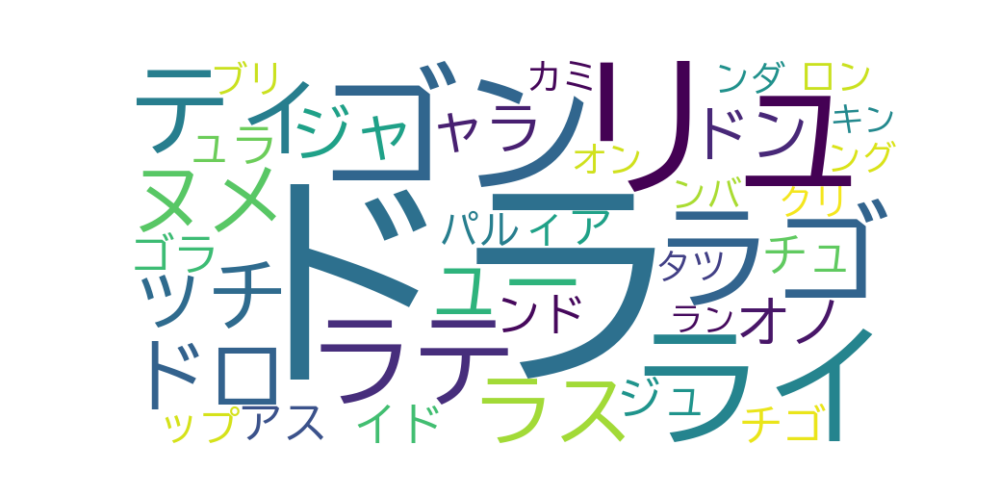

In [27]:
pokemon_type = "Dragon"
create_word_cloud(df_name, language, pokemon_type)

For the Dragon type, multiple pokemons share the kanas :
- ドラ (dora) and ゴン (gon) which comes directly from the english word dragon (pronounced doragon in japanese)
- リュ (ryu) which means 竜 (ryuu - dragon)

### Class distribution

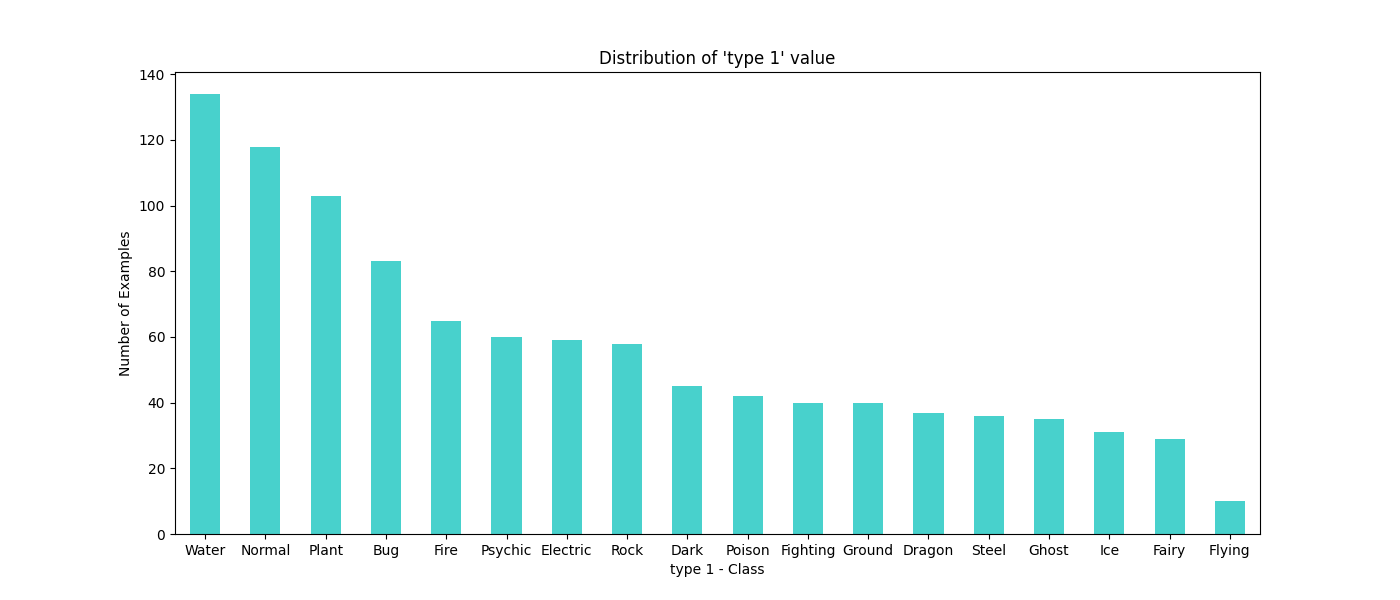

In [28]:
class_counts = df['Type 1'].value_counts(dropna=False)
plt.figure(figsize=(14, 6))
class_counts.plot(kind='bar', color="mediumturquoise")

plt.title("Distribution of 'type 1' value")
plt.xlabel('type 1 - Class')
plt.ylabel('Number of Examples')
plt.xticks(rotation=0)
plt.show()

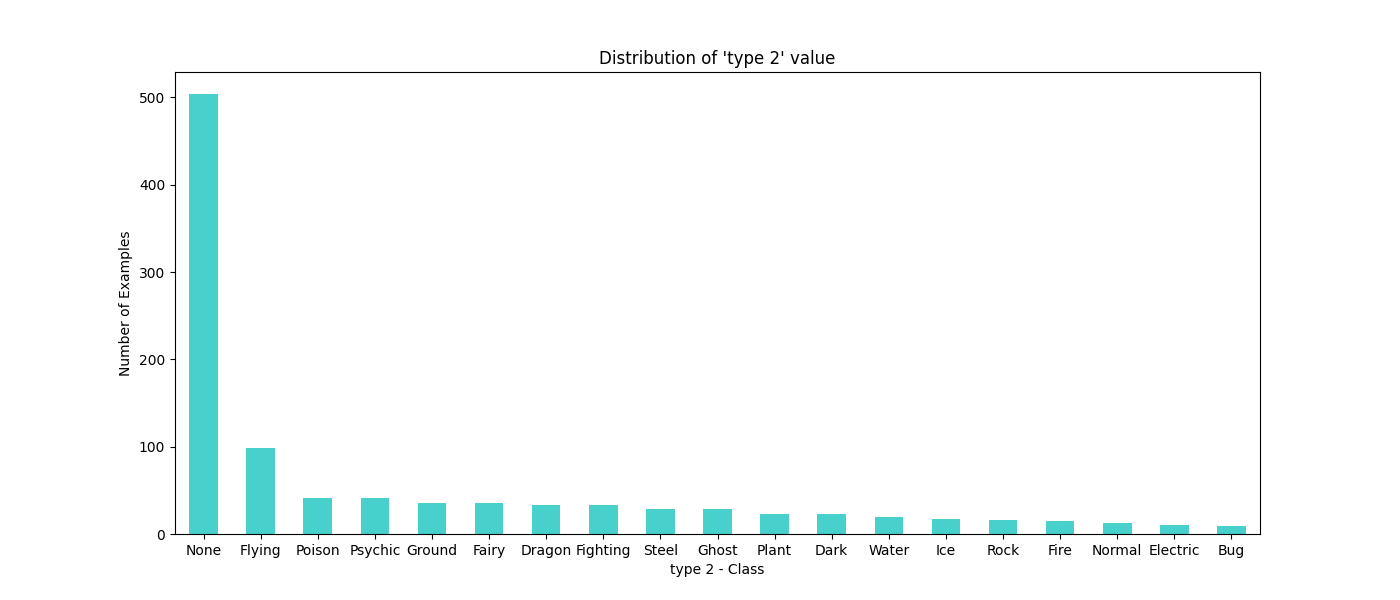

In [29]:
class_counts = df['Type 2'].value_counts(dropna=False)

plt.figure(figsize=(14, 6))
class_counts.plot(kind='bar', color="mediumturquoise")
plt.title("Distribution of 'type 2' value")
plt.xlabel('type 2 - Class')
plt.ylabel('Number of Examples')
plt.xticks(rotation=0)
plt.show()

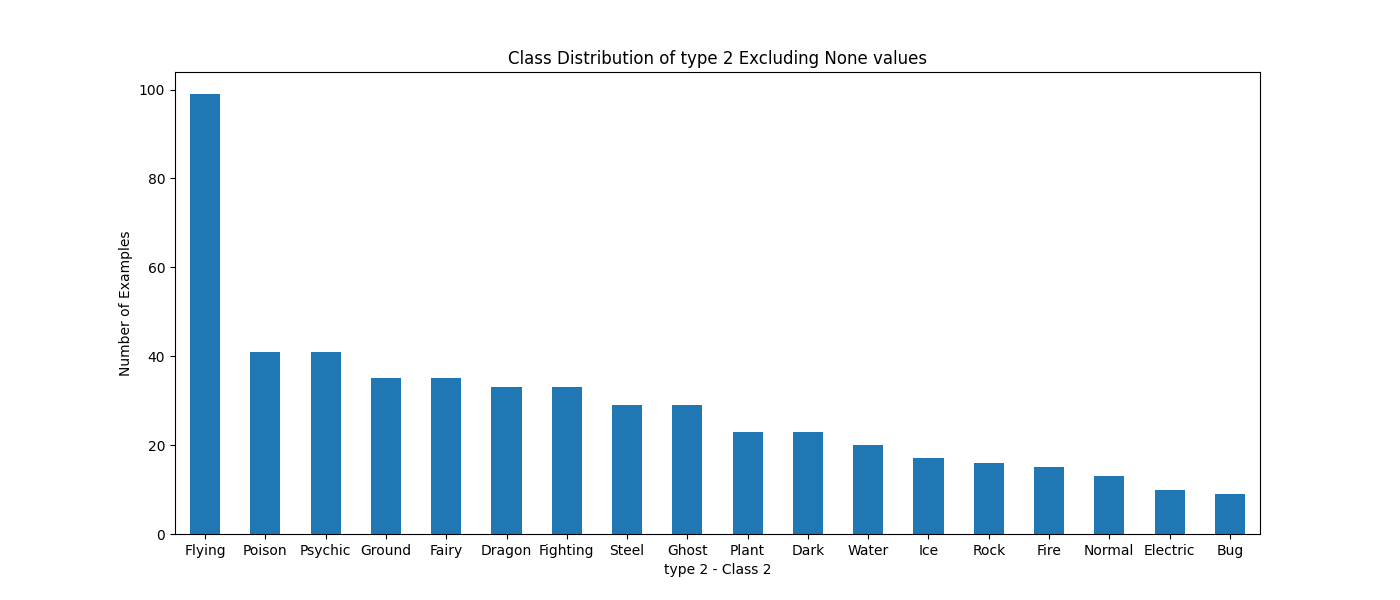

In [30]:
class_counts = df['Type 2'].value_counts()

plt.figure(figsize=(14, 6))
class_counts.plot(kind='bar')
plt.title('Class Distribution of type 2 Excluding None values')
plt.xlabel('type 2 - Class 2')
plt.ylabel('Number of Examples')
plt.xticks(rotation=0)
plt.show()

One can also transform the none values of the second type into the first type.

In [31]:
df['Type2_WO_None'] = df['Type 2']
df.loc[df['Type 2'].isna(),'Type2_WO_None'] = df.loc[df['Type 2'].isna(),'Type 1']

Representation of the joint frequency of two types. We employ the tool of confusion matrix to highlight the joint frequencies of Type 1 and Type 2 variables

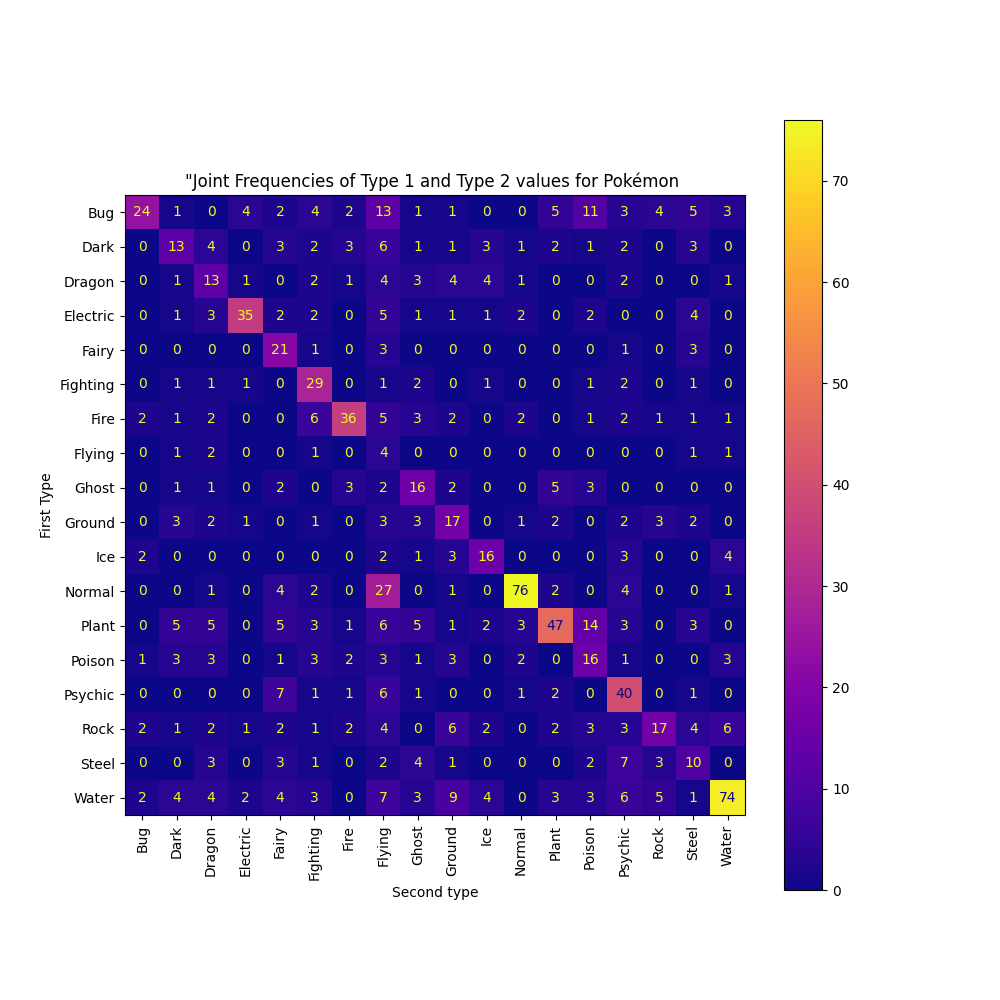

In [32]:
cm = confusion_matrix(df['Type 1'], df['Type2_WO_None'])
unique_label = np.unique([df["Type 1"], df["Type2_WO_None"]])
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=unique_label)
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax, xticks_rotation='vertical', cmap="plasma")
ax.set_xlabel('Second type')
ax.set_ylabel('First Type')

# Set title
plt.title('"Joint Frequencies of Type 1 and Type 2 values for Pokémon ')
plt.show()

# Baseline prediction model

In [33]:
df.columns

Index(['French', 'English', 'German', 'Kanas', 'Registered', 'Type 1',
       'Type 2', 'image_resized', 'Image', 'vector', 'color', 'rgb_values',
       'alpha_channel', 'mean_color_value', 'dominant_color',
       'Kanas_substrings', 'Type2_WO_None'],
      dtype='object', name=0)

For the baseline model, we decided to use textual data as well as Images and create a model based on both an NLP classifier and a CNN classifier

**NLP Classifier**
Let's formalize the NLP task:
* X: a dataframe containing columns 'French', 'English', 'German', 'Kanas', 'Registered'.
* y: a "one hot encoding"-like vector of all element among the possible values for 'Type 1' and 'Type 2' variables. This vector contains at most 2 occurrences of value 1, with all other components equal to 0.

**CNN classifier**
Let's formalize the Computeur vision task :
* X Image as a tensor
* y: a "one hot encoding"-like vector of all element among the possible values for 'Type 1' and 'Type 2' variables. This vector contains at most 2 occurrences of value 1, with all other components equal to 0.

**Final Classifier**
These two portions allow us to obtain probabilities for each of the types.
The final result, our XNLP model, is obtained by considering a centroid of these averages:

$$\text{averaged\_probas} = \text{self.weightNLP} \times \text{probasNLP} + (1 - \text{self.weightNLP}) \times \text{probasCNN}$$


### Transforming the data

The input of both the NLP and the CNN classifiers are the same, a dataframe containing : 
* with one column for the images, and the
* other columns for the names in different languages
* And a numpy array containing the types one hot encoded

In [34]:
class Transform_dataset(Dataset):
    def __init__(self, data, expected_size=(128,128)):
        self.expected_size = expected_size
        imgs = []
        for img in data:
            img = Image.fromarray(img)
            img.thumbnail(self.expected_size, Image.Resampling.LANCZOS)
            img = self.padding(img)
            imgs.append(np.array(img))
        imgs = np.array(imgs)
        self.data = torch.Tensor(imgs).reshape(-1, 4, expected_size[0], expected_size[1])
    def padding(self, img):
        desired_size = self.expected_size
        delta_width = desired_size[0] - img.size[0]
        delta_height = desired_size[1] - img.size[1]
        pad_width = delta_width // 2
        pad_height = delta_height // 2
        padding = (pad_width, pad_height, delta_width - pad_width, delta_height - pad_height)
        return ImageOps.expand(img, padding)

In [35]:
class Data :
    def get_data_XNLP(df : pd.DataFrame) -> pd.DataFrame:
        X = df[['French', 'English', 'German', 'Kanas', 'Registered']]
        return X

    def get_data_CNN(df : pd.DataFrame, y : np.ndarray, batch_size : int = 8, sizeX : int = 128, sizeY : int = 128) -> pd.DataFrame:

        X = df['Image'].to_list()
        dataset = Transform_dataset(X, (sizeX, sizeY))
        if y is None:
            y = np.zeros((len(X), 18))

        dataset = TensorDataset(dataset.data, torch.from_numpy(y))
        dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

        return dataloader

### Class NLPClassifier

In [36]:
class NLPClassifier(BaseEstimator) :

    def __init__(self, max_features : int = 1000, max_iter : int = 1000, class_weight : str = 'balanced') :

        self.num_classes = 18
        # the minimum size of the n-grams
        self.min_gram_range = 1
        # the maximum size of the n-grams
        self.max_gram_range = 3

        # consider the top 'max_features' for NLP model
        self.max_features = max_features
        # the maximum number of iterations for the logistic regression
        self.max_iter = max_iter
        # balance for the logistic regression
        self.class_weight = class_weight

    def set_model(self) :

        transformer_element = lambda name,column : (name, TfidfVectorizer(analyzer="char", ngram_range=(self.min_gram_range, self.max_gram_range), max_features=self.max_features), column)

        transformer = ColumnTransformer(
            transformers=[
                transformer_element("en", "English"),
                transformer_element("de", "German"),
                transformer_element("fr", "French"),
                transformer_element("ka", "Kanas"),
                transformer_element("re", "Registered"),
            ],
            remainder="drop",
            sparse_threshold=0,
        )

        model = MultiOutputClassifier(LogisticRegression(max_iter=self.max_iter, class_weight=self.class_weight))

        self.model = make_pipeline(transformer, model)


    def fit(self, X : pd.DataFrame, y : np.ndarray) :

        if not isinstance(X, pd.DataFrame) :
            raise TypeError(f"The input should be a pandas Dataframe, found {type(X)} instead")

        if not isinstance(y, np.ndarray) :
            raise TypeError(f"The input should be a pandas Dataframe, found {type(y)} instead")

        self.set_model()

        self.model.fit(X, y)

        self.is_fitted_ = True


    def predict_proba(self, X : pd.DataFrame) :
        """
        Return the raw probabilities of each class (transformations may be applied
        afterwards when calling the final classifier)
        """
        if not isinstance(X, pd.DataFrame) :
            raise TypeError(f"The input should be a pandas Dataframe, found {type(X)} instead")

        check_is_fitted(self)

        pred_probas = self.model.predict_proba(X)
        pred_probas = np.array(pred_probas)[:,:,1].T

        return pred_probas

### Class CNNClassifier

In [37]:
class CNN(nn.Module):

    def __init__(self, img_height, img_width, channels, n_labels):

        super(CNN, self).__init__()

        self.conv1 = nn.Conv2d(channels, 16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(16)

        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(32)

        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(64)

        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(128)

        self.conv5 = nn.Conv2d(128, 150, kernel_size=3, padding=1)
        self.bn5 = nn.BatchNorm2d(150)

        self.fc1 = nn.Linear(150 * (img_height // 32) * (img_width // 32), 64)
        self.fc2 = nn.Linear(64, n_labels)


    def forward(self, x):

        x = F.relu(self.bn1(self.conv1(x)))
        x = F.max_pool2d(x, 2)

        x = F.relu(self.bn2(self.conv2(x)))
        x = F.max_pool2d(x, 2)

        x = F.relu(self.bn3(self.conv3(x)))
        x = F.max_pool2d(x, 2)

        x = F.relu(self.bn4(self.conv4(x)))
        x = F.max_pool2d(x, 2)

        x = F.relu(self.bn5(self.conv5(x)))
        x = F.max_pool2d(x, 2)

        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

In [38]:
class CNNClassifier :

    def __init__(
        self, learning_rate : float = 0.001, epochs : int = 10, batch_size : int = 8, sizeX : int = 128, sizeY : int = 128,
    ):
        self.num_classes = 18
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.batch_size = batch_size
        self.device = torch.device(
            "cuda" if torch.cuda.is_available() else "cpu"
        )
        self.sizeX = sizeX
        self.sizeY = sizeY
        self.model = CNN(self.sizeX, self.sizeY, channels=4, n_labels=self.num_classes)
        self.criterion = nn.BCEWithLogitsLoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)


    def fit(self, train_loader : DataLoader):

        self.model.to(self.device)

        self.model.train()

        # Training loop
        for epoch in range(self.epochs):

            for inputs, labels in train_loader:

                inputs, labels = inputs.to(self.device), labels.to(self.device).to(torch.float)

                self.optimizer.zero_grad()

                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)

                loss.backward()
                self.optimizer.step()

            print(f"Epoch [{epoch+1}/{self.epochs}], Loss: {loss.item():.4f}")



    def predict_proba(self, test_loader : DataLoader) -> np.ndarray:

        self.model.eval()

        probabilities = []

        with torch.no_grad():

            for inputs,_ in test_loader :
                inputs = inputs.to(self.device)
                outputs = self.model(inputs)
                probabilities.extend(torch.sigmoid(outputs).cpu().numpy())
        return np.array(probabilities)

### Final classifier using features from both NLPClassifier and CNNClassifier

In [39]:
class Classifier(BaseEstimator):

    def __init__(self, normalisation : str | None = None, weightNLP : float = 1., threshold : float = .07, **kwargs):

        self.num_classes = 18
        self.modelNLP = NLPClassifier(**kwargs)
        self.modelCNN = CNNClassifier(**kwargs)

        # how to normalise the probabilities
        normalisation_methods = {None, 'softmax', 'sum'}
        if not normalisation in normalisation_methods:
            raise ValueError(f"The normalisation method {normalisation} is not in {normalisation_methods}")
        self.normalisation = normalisation

        # this factor indicated the weight of the probability
        # of the NLP model
        if (weightNLP < 0.) or (weightNLP > 1.) :
            raise ValueError(f"The weight of the NLP model should be in [0,1], but found {weightNLP}")
        self.weightNLP = weightNLP

        # the threshold above which a second type is predicted
        # (to be modulated with the normalisation)
        self.threshold = threshold


    def fit(self, df : pd.DataFrame, y : np.ndarray):

        if not isinstance(df, pd.DataFrame) :
            raise TypeError(f"The input should be a pandas Dataframe, found {type(df)} instead")

        XNLP = Data.get_data_XNLP(df)
        train_loaderCNN = Data.get_data_CNN(df, y, self.modelCNN.batch_size, self.modelCNN.sizeX, self.modelCNN.sizeY)


        self.modelNLP.fit(XNLP, y)
        self.modelCNN.fit(train_loaderCNN)

        self.is_fitted_ = True

        return self


    def predict_proba(self, df : pd.DataFrame) -> np.ndarray:

        check_is_fitted(self)

        if not isinstance(df, pd.DataFrame) :
            raise TypeError(f"The input should be a pandas Dataframe, found {type(df)} instead")

        XNLP = Data.get_data_XNLP(df)
        test_loaderCNN = Data.get_data_CNN(df, None, self.modelCNN.batch_size, self.modelCNN.sizeX, self.modelCNN.sizeY)

        probasNLP = self.modelNLP.predict_proba(XNLP)
        probasCNN = self.modelCNN.predict_proba(test_loaderCNN)

        averaged_probas = self.weightNLP*probasNLP + (1- self.weightNLP)*probasCNN

        if self.normalisation == 'softmax' :
            averaged_probas = softmax(averaged_probas, axis=1)
        elif self.normalisation == "mean" :
            row_sums = averaged_probas.sum(axis=1).reshape(-1, 1)
            averaged_probas /= row_sums
        # if normalisation == None do nothing

        return averaged_probas


    def predict(self, df : pd.DataFrame) -> np.ndarray:

        pred_probs = self.predict_proba(df)

        preds = np.zeros_like(pred_probs)

        for i,pred_proba in enumerate(pred_probs) :

            t = np.argsort(pred_proba)

            # no matter what, the biggest probability is considered
            preds[i, t[-1]] = 1

            second_best = t[-2]
            # the second best is considered only if higher than the threshold
            if pred_proba[second_best] > self.threshold:
                preds[i, second_best] = 1

        return preds
    

def get_estimator():
    clf = Classifier()
    return clf

In [40]:
targets = ["Type 1", "Type 2"]
X = df.drop(columns=targets)
y = df[targets].apply(lambda x: [x['Type 1']] if pd.isna(x['Type 2']) else [x['Type 1'], x['Type 2']], axis=1)
mlb = MultiLabelBinarizer()
y = pd.DataFrame(mlb.fit_transform(y), columns=mlb.classes_)

In [41]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [42]:
clf = get_estimator()
clf.fit(X_train, y_train.to_numpy())

Epoch [1/10], Loss: 0.3701
Epoch [2/10], Loss: 0.2239
Epoch [3/10], Loss: 0.2822
Epoch [4/10], Loss: 0.3406
Epoch [5/10], Loss: 0.3024
Epoch [6/10], Loss: 0.2155
Epoch [7/10], Loss: 0.2060
Epoch [8/10], Loss: 0.2809
Epoch [9/10], Loss: 0.2801
Epoch [10/10], Loss: 0.2655


Classifier()

In [43]:
print(classification_report(y_test, clf.predict(X_test), target_names=mlb.classes_))

              precision    recall  f1-score   support

         Bug       0.33      0.44      0.38        18
        Dark       0.31      0.27      0.29        15
      Dragon       0.47      0.54      0.50        13
    Electric       0.65      0.69      0.67        16
       Fairy       0.33      0.27      0.30        11
    Fighting       0.21      0.22      0.22        18
        Fire       0.75      0.50      0.60        12
      Flying       0.30      0.50      0.37        16
       Ghost       0.18      0.14      0.16        14
      Ground       0.21      0.38      0.27        16
         Ice       0.67      0.29      0.40         7
      Normal       0.34      0.61      0.44        23
       Plant       0.32      0.58      0.41        26
      Poison       0.45      0.42      0.43        24
     Psychic       0.32      0.45      0.38        22
        Rock       0.43      0.64      0.51        14
       Steel       0.29      0.31      0.30        13
       Water       0.32    